In [2]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [3]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import optuna
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from icecream import ic
from polars import col
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader, TensorDataset

from src.data.database_manager import DatabaseManager
from src.features.labels import add_labels
from src.features.resampling import (
    add_normalized_timestamp,
    interpolate_and_fill_nulls,
    resample_at_10_hz_equidistant,
)
from src.features.scaling import scale_min_max, scale_robust_standard, scale_standard
from src.features.transforming import merge_dfs
from src.features.utils import to_describe
from src.log_config import configure_logging
from src.models.architectures import MultiLayerPerceptron
from src.models.data_loader import transform_df_to_arrays
from src.models.sample_creation import create_samples, make_sample_set_balanced
from src.models.scalers import StandardScaler3D
from src.models.utils import get_device

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

db = DatabaseManager()

In [4]:
with db:
    df = db.get_table("Merged_and_Labeled_Data")

In [5]:
df.hvplot(
    x="timestamp",
    y=["temperature", "eda_tonic", "pupil_mean", "pupil_mean_tonic"],
    groupby="trial_id",
    height=300,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'5b91412f-19f5-4125-a136-7eebff48a8fa': {'version…

In [6]:
intervals = {
    # "decreases": "decreasing_intervals",
    "decreases": "major_decreasing_intervals",
    "increases": "strictly_increasing_intervals_without_plateaus",
}

samples = create_samples(df, intervals, length_ms=5000)
samples = make_sample_set_balanced(samples)
samples


trial_id,trial_number,participant_id,timestamp,temperature,rating,eda_raw,eda_tonic,eda_phasic,ppg_raw,ppg_ibi_shimmer,heartrate,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,pupil_mean_tonic,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals,normalized_timestamp_decreases,normalized_timestamp_increases,label,sample_id
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16,f64,f64,u8,u16
23,1,3,236209.3687,0.46397,0.455,6.535266,6.632551,-0.097284,1322.213354,-1.64591,59.286762,3.370299,3.853124,3.853168,3.370253,3.611711,3.65844,0.000062,0.000858,0.003909,0.006845,0.008707,51400.0,658,1,111,67,0,0,0,0,0,0.0,null,1,67
23,1,3,236309.3687,0.46397,0.455,6.531334,6.634214,-0.10288,1325.943743,-0.927363,59.280127,3.338885,3.801375,3.801239,3.343706,3.572473,3.655486,0.000052,0.001115,0.00354,0.007678,0.007475,51500.0,658,1,111,67,0,0,0,0,0,100.0,null,1,67
23,1,3,236409.3687,0.46397,0.455,6.529842,6.635822,-0.105981,1392.068464,-0.304778,59.277321,3.327683,3.753263,3.753463,3.336321,3.544892,3.653064,0.000065,0.001097,0.0043,0.006562,0.006595,51600.0,658,1,111,67,0,0,0,0,0,200.0,null,1,67
23,1,3,236509.3687,0.46397,0.455,6.527551,6.638158,-0.110607,1464.893286,-1.779926,59.285558,3.33325,3.726177,3.729844,3.335734,3.532789,3.651319,0.00008,0.001164,0.003691,0.007261,0.007447,51700.0,658,1,111,67,0,0,0,0,0,300.0,null,1,67
23,1,3,236609.3687,0.46397,0.442158,6.529655,6.640425,-0.11077,1441.447011,-0.096634,59.309224,3.337177,3.712914,3.726838,3.334898,3.530868,3.650365,0.000077,0.001197,0.003455,0.008919,0.008374,51800.0,658,1,111,67,0,0,0,0,0,400.0,null,1,67
23,1,3,236709.3687,0.46397,0.413454,6.533682,6.643057,-0.109375,1415.23236,-1.679425,59.361471,3.333878,3.702869,3.727131,3.335094,3.531112,3.650288,0.000077,0.00095,0.003766,0.010644,0.009061,51900.0,658,1,111,67,0,0,0,0,0,500.0,null,1,67
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
383,5,37,1.0484e6,0.31191,0.745,16.635482,16.600092,0.03539,1537.864376,4.177162,76.62132,4.762554,4.599494,4.572858,4.779266,4.676062,4.610185,0.000011,0.00001,0.000455,0.0,0.000014,4500.0,265,5,0,0,1911,1911,1147,0,0,null,4500.0,0,2684
383,5,37,1.0485e6,0.322781,0.745,16.636424,16.596277,0.040147,1491.172861,-3.545372,76.019,4.908121,4.839422,4.593933,4.749817,4.671875,4.60684,0.00003,0.00001,0.000721,0.0,0.000022,4600.0,265,5,0,0,1911,1911,1147,0,0,null,4600.0,0,2684


In [61]:
samples = samples.select(
    "sample_id",
    "participant_id",
    "rating",
    "temperature",
    "eda_raw",
    "eda_tonic",
    "eda_phasic",
    "pupil_mean",
    "label",
)
samples

sample_id,participant_id,rating,temperature,eda_raw,eda_tonic,eda_phasic,pupil_mean,label
u16,u8,f64,f64,f64,f64,f64,f64,u8
1,3,1.0,1.0,6.664139,6.700072,-0.035933,4.254981,1
1,3,1.0,0.999963,6.708477,6.712371,-0.003893,4.256771,1
1,3,1.0,0.999829,6.744398,6.72465,0.019749,4.260455,1
1,3,1.0,0.999576,6.767904,6.737501,0.030404,4.272392,1
1,3,1.0,0.999205,6.790309,6.748903,0.041406,4.293056,1
1,3,1.0,0.998715,6.810005,6.760571,0.049434,4.320735,1
…,…,…,…,…,…,…,…,…
4669,50,0.201534,0.550648,28.014491,27.649801,0.364691,5.54375,0
4669,50,0.281235,0.566078,28.028736,27.657549,0.371187,5.555003,0


In [62]:
samples["label"].value_counts()

label,count
u8,u32
0,70050
1,116750


In [63]:
70050 / 50

1401.0

In [91]:
X, y, groups = transform_df_to_arrays(
    samples,
    [
        # "temperature",  # only for visualization
        # "rating"
        # "eda_raw",
        # "eda_tonic",
        "pupil_mean",
    ],
)


@ipywidgets.interact(trial=(0, X.shape[0] - 1))
def plot_trial(trial):
    for i in range(X.shape[2]):
        plt.plot(X[trial, :, i])
    # plt.ylim(0, 1.05)

interactive(children=(IntSlider(value=1867, description='trial', max=3735), Output()), _dom_classes=('widget-i…

In [92]:
X.shape

(3736, 50, 1)

In [93]:
# np.save("data/x.npy", x)
# np.save("data/y.npy", y)
# np.save("data/groups.npy", groups)

In [94]:
# Create a single train-test split while respecting group structure in the data
splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
assert set(groups[train_idx]).isdisjoint(set(groups[test_idx])), "Overlap in groups"
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


In [95]:
np.isnan(X_train).any()

np.False_

In [96]:
import numpy as np


def check_nans(arr):
    """
    Check if a NumPy array contains any NaN values.
    Returns True if NaN values are found, False otherwise.
    Also prints the indices where NaN values are located.

    Parameters:
        arr: numpy.ndarray - Input array to check

    Returns:
        bool - True if NaN values exist, False otherwise
    """
    # Check if array contains any NaN
    has_nans = np.isnan(arr).any()

    if has_nans:
        # Get the indices where NaN values are located
        nan_indices = np.where(np.isnan(arr))
        print(f"NaN values found at indices: {nan_indices}")

        # If array is multi-dimensional, print the actual NaN values
        if arr.ndim > 1:
            print("NaN values:")
            print(arr[nan_indices])
    else:
        print("No NaN values found in array")

    return has_nans


# Example usage:
# arr = np.array([[1, 2, np.nan], [4, np.nan, 6]])
check_nans(X_train)

No NaN values found in array


np.False_

In [97]:
from sklearn.metrics import accuracy_score
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels import FlatDist, ScipyDist

eucl_dist = FlatDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=eucl_dist)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.575

In [98]:
batch_size = 64
device = get_device()

13:44:37 | INFO    | root | Using device: mps


In [99]:
def create_dataloaders(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    batch_size: int,
    is_test: bool = True,
) -> tuple[DataLoader, DataLoader]:
    # Sanity check
    assert len(X_train.shape) == len(X_test.shape) == 3, (
        "X_train and X_test must have 3 dimensions: (samples, timesteps, features)"
    )

    # scaler = StandardScaler3D()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    train_data = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train).view(-1, 1),
    )
    test_data = TensorDataset(
        torch.FloatTensor(X_test),
        torch.FloatTensor(y_test).view(-1, 1),
    )
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

    dataset = "Test" if is_test else "Validation"
    logging.debug(
        f"Train Data: {len(train_data)} samples, "
        f"{dataset} Data: {len(test_data)} samples"
    )

    return train_loader, test_loader


train_loader, test_loader = create_dataloaders(
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=batch_size,
)

13:44:38 | DEBUG   | root | Train Data: 1816 samples, Test Data: 1920 samples


In [100]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epochs: int,
    is_test: bool = True,
) -> dict[str, list[float]]:
    dataset = "test" if is_test else "validation"
    history = {
        "train_accuracy": [],
        "train_loss": [],
        f"{dataset}_accuracy": [],
        f"{dataset}_loss": [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # for acc metric only
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Calculate training accuracy
            y_pred_classes = (torch.sigmoid(outputs) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total if total > 0 else 0
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

        # Store the metrics in the history dictionary
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history[f"{dataset}_loss"].append(test_loss)
        history[f"{dataset}_accuracy"].append(test_accuracy)

        # Log progress
        max_digits = len(str(epochs))
        logging.debug(
            f"E[{+epoch + 1:>{max_digits}d}/{epochs}] "
            f"| train {epoch_loss:.4f} ({epoch_acc:.1%}) "
            f"· {dataset} {test_loss:.4f} ({test_accuracy:.1%})"
        )

    return history


def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred_logits = model(X_batch)
            loss = criterion(y_pred_logits, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            # Metric here is acc
            y_pred_classes = (torch.sigmoid(y_pred_logits) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

    average_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return average_loss, accuracy


In [101]:
class LSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
    ):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(input_size=X_train.shape[2], hidden_size=256, num_layers=1).to(device)

In [102]:
lr = 1e-3
epochs = 20
model = MultiLayerPerceptron(
    input_size=X.shape[2] * X.shape[1],  # 2D input length
    hidden_size=2048,
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

history = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=epochs,
)

13:44:40 | DEBUG   | root | E[ 1/20] | train 1.1458 (57.9%) · test 0.6609 (62.5%)
13:44:40 | DEBUG   | root | E[ 2/20] | train 0.6605 (62.5%) · test 0.6537 (62.5%)
13:44:40 | DEBUG   | root | E[ 3/20] | train 0.6568 (62.5%) · test 0.6510 (62.6%)
13:44:41 | DEBUG   | root | E[ 4/20] | train 0.6586 (63.3%) · test 0.6509 (62.9%)
13:44:41 | DEBUG   | root | E[ 5/20] | train 0.6568 (62.6%) · test 0.6632 (64.6%)
13:44:41 | DEBUG   | root | E[ 6/20] | train 0.6560 (62.7%) · test 0.6522 (63.2%)
13:44:42 | DEBUG   | root | E[ 7/20] | train 0.6520 (62.9%) · test 0.6521 (62.7%)
13:44:42 | DEBUG   | root | E[ 8/20] | train 0.6501 (63.3%) · test 0.6575 (62.8%)
13:44:42 | DEBUG   | root | E[ 9/20] | train 0.6552 (62.9%) · test 0.6453 (63.1%)
13:44:42 | DEBUG   | root | E[10/20] | train 0.6480 (63.2%) · test 0.6425 (63.6%)
13:44:43 | DEBUG   | root | E[11/20] | train 0.6531 (64.3%) · test 0.6436 (63.6%)
13:44:43 | DEBUG   | root | E[12/20] | train 0.6465 (64.0%) · test 0.6451 (65.1%)
13:44:43 | DEBUG

18:23:45 | DEBUG   | root | E[20/20] | train 0.6073 (68.1%) · test 0.6094 (67.7%)


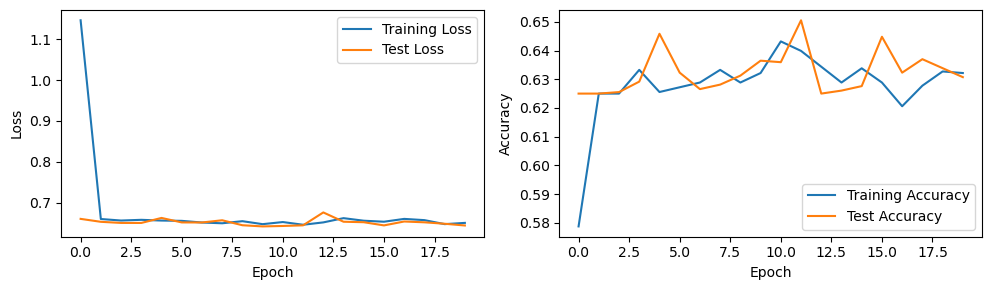

In [103]:
def plot_single_model_history(history):
    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["test_accuracy"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_single_model_history(history)

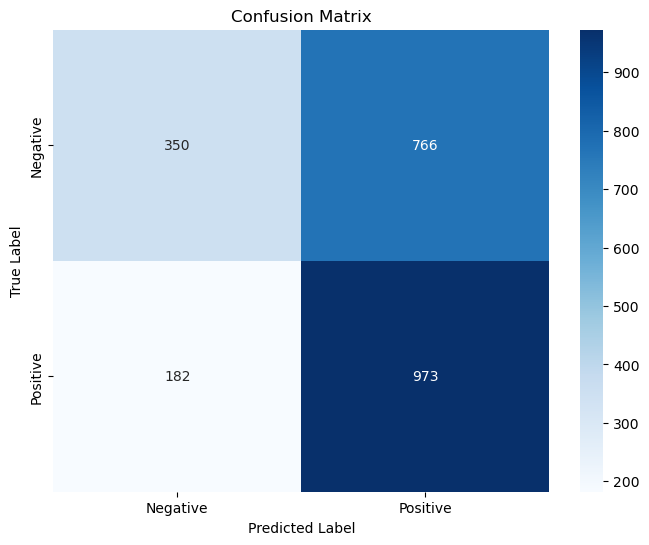

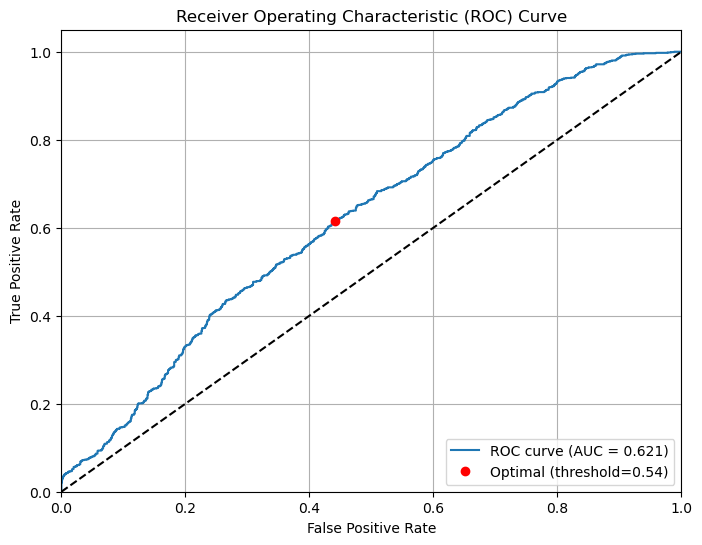

In [ ]:
# NOTE: the dataset is imbalanced, so accuracy is not a good metric


def get_confusion_matrix(
    model: nn.Module,
    test_loader: DataLoader,
    threshold: float = 0.5,
) -> np.ndarray:
    """
    Calculate confusion matrix for binary classification.
    Returns a 2x2 numpy array where:
    [0,0] = TN, [0,1] = FP
    [1,0] = FN, [1,1] = TP
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_pred_batch = (torch.sigmoid(outputs) >= threshold).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(y_pred_batch)

    return confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(conf_matrix: np.ndarray) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def plot_roc_curve(
    model: nn.Module,
    test_loader: DataLoader,
) -> None:
    """
    Plot ROC curve and calculate AUC score for binary classification.
    """
    model.eval()
    y_true = []
    y_scores = []

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_scores_batch = torch.sigmoid(outputs).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_scores.extend(y_scores_batch)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "k--")  # diagonal line

    # Add marker for optimal threshold
    plt.plot(
        fpr[optimal_idx],
        tpr[optimal_idx],
        "ro",
        label=f"Optimal (threshold={optimal_threshold:.2f})",
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


conf_matrix = get_confusion_matrix(model, test_loader, threshold=0.5)
plot_confusion_matrix(conf_matrix)
plot_roc_curve(model, test_loader)

In [ ]:
# from dataclasses import dataclass


# @dataclass
# class TimesNetConfig:
#     task_name: str = "classification"
#     is_training: int = 1
#     model_id: str = "Heartbeat"
#     model: str = "TimesNet"
#     data: str = "UEA"
#     e_layers: int = 3
#     batch_size: int = 16
#     d_model: int = 16
#     d_ff: int = 32
#     top_k: int = 1
#     des: str = "Exp"
#     itr: int = 1
#     learning_rate: float = 0.001
#     train_epochs: int = 30
#     patience: int = 10
#     seq_len: int = 50
#     label_len: int = 1
#     pred_len: int = 1
#     num_kernels: int = 32
#     enc_in: int = 1
#     embed: int = 8
#     freq: str = "H"
#     dropout: float = 0.1
#     num_class: int = 2

#     def to_args_list(self) -> list:
#         """Convert config to command line arguments list"""
#         args = []
#         for key, value in self.__dict__.items():
#             args.extend([f"--{key}", str(value)])
#         return args


# # Example usage:
# configs = TimesNetConfig()
# configs

# from time_series_library.models import TimesNet

# model = TimesNet.Model(configs)


In [ ]:
from sklearn.metrics import accuracy_score
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels import FlatDist, ScipyDist

eucl_dist = FlatDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=eucl_dist)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6125055041831792

In [ ]:
type(clf)

sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier

In [ ]:
isinstance(model, torch.nn.Module)

True

In [ ]:
import sktime

sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier.__mro__

(sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier,
 sktime.base._panel.knn._BaseKnnTimeSeriesEstimator,
 sktime.classification.base.BaseClassifier,
 sktime.base._base_panel.BasePanelMixin,
 sktime.base._base.BaseEstimator,
 sktime.base._base.BaseObject,
 sktime.utils._estimator_html_repr._HTMLDocumentationLinkMixin,
 skbase.base._base.BaseObject,
 skbase.base._tagmanager._FlagManager,
 object)

In [ ]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate

minirocket_multi = MiniRocketMultivariate()
# minirocket_multi.fit(X_train)


In [ ]:
X_train.shape

(2202, 500, 1)